In [1]:
import warnings
import textblob
import string
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from os import path
from PIL import Image
from nltk import *
from textblob import TextBlob
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from wordcloud import ImageColorGenerator
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YangWang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YangWang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_tweets(tweets_file):
    cols = ["date", "time", "username", "tweet", "hashtags", "likes_count", "replies_count", "retweets_count"]
    df = pd.read_csv(tweets_file, usecols=cols)
    print("# of tweets: {}".format(df.shape[0]))
    df.sort_values(by="date", ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

df = load_tweets(tweets_file="../data/forex.csv")
df.head()

# of tweets: 1444416


,date,time,username,tweet,replies_count,retweets_count,likes_count,hashtags
0,2007-03-27,16:37:26,ioverlord,Director-General of DG Competition Philip Lowe...,0,0,0,[]
1,2007-03-27,16:37:26,ioverlord,Director-General of DG Competition Philip Lowe...,0,0,0,[]
2,2008-02-08,17:36:13,cnafrontpage,ADB chief says Asia not 'immune' to US slowdow...,0,0,0,[]
3,2008-02-08,17:36:13,cnafrontpage,ADB chief says Asia not 'immune' to US slowdow...,0,0,0,[]
4,2008-05-06,16:12:09,philiplowe,Trying to re-build my blog and my site,0,0,0,[]


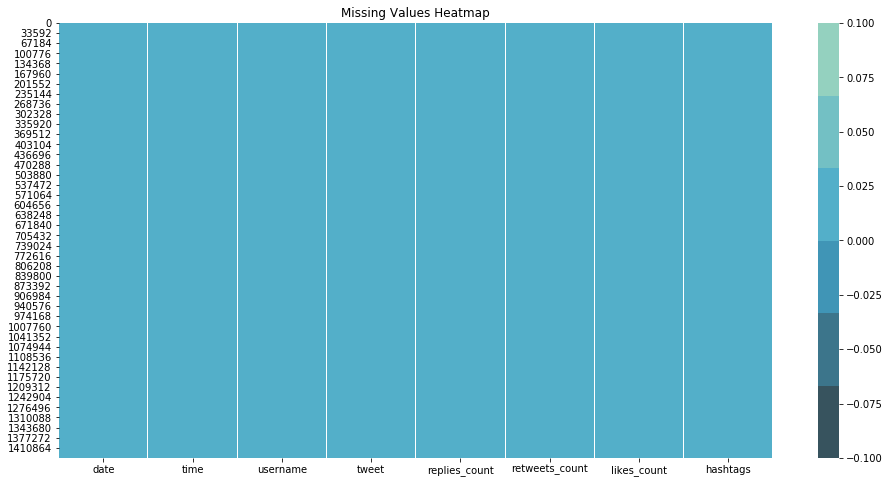

In [3]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
plt.title("Missing Values Heatmap")
plt.show()

In [4]:
before = df.shape[0]
print("# of tweets before dropping duplicates: {}".format(before))
df.drop_duplicates(inplace=True)
after = df.shape[0]
print("# of tweets after dropping duplicates: {}".format(after))
print("# of tweets being dropped: {}".format(before-after))

# of tweets before dropping duplicates: 1444416
# of tweets after dropping duplicates: 1297358
# of tweets being dropped: 147058


In [5]:
# Dictionary of English Contractions
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [6]:
# Reference from https://github.com/Deffro/text-preprocessing-techniques/blob/master/techniques.py
import re
import nltk
from functools import partial
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

class TweetsPreprocessor:
    
    def __init__(self, contractions_dict, lower=True):
        self.contractions_dict = contractions_dict
        self.lower = lower
        
    def remove_unicode(self, text):
        """ Removes unicode strings like "\u002c" and "x96" """
        text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
        text = re.sub(r'[^\x00-\x7f]',r'',text)
        return text

    def replace_URL(self, text):
        """ Replaces url address with "url" """
        text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
        text = re.sub(r'#([^\s]+)', r'\1', text)
        return text

    def replace_at_user(self, text):
        """ Replaces "@user" with "atUser" """
        text = re.sub('@[^\s]+','atUser',text)
        return text

    def remove_hashtag_in_front_of_word(self, text):
        """ Removes hastag in front of a word """
        text = re.sub(r'#([^\s]+)', r'\1', text)
        return text

    # Function for expanding contractions
    def expand_contractions(self, text, contractions_dict=contractions_dict):
        # Regular expression for finding contractions
        contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
        def replace(match):
            return contractions_dict[match.group(0)]
        return contractions_re.sub(replace, text)

    def ultimate_clean(self, text):
        if self.lower:
            text = text.lower()
        text = self.remove_unicode(text)
        text = self.replace_URL(text)
        text = self.replace_at_user(text)
        text = self.remove_hashtag_in_front_of_word(text)
        text = self.expand_contractions(text)
        return text

def count_slang(text):
    """
    Creates a dictionary with slangs and their equivalents and replaces them.
    Input: a text
    Output: how many slang words and a list of found slangs.
    """
    with open('slang.txt', encoding="utf-8") as file:
        slang_map = dict(map(str.strip, line.partition('\t')[::2])
        for line in file if line.strip())
    # Longest first for regex
    slang_words = sorted(slang_map, key=len, reverse=True)
    regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
    replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])
    
    slangCounter = 0
    slangsFound = []
    tokens = nltk.word_tokenize(text)
    for word in tokens:
        if word in slang_words:
            slangsFound.append(word)
            slangCounter += 1
    return slangCounter, slangsFound

In [7]:
df["date"] = pd.to_datetime(df.date)
df["time"] = pd.to_timedelta(df.time)
df["clean_tweet"] = df["tweet"].apply(lambda x: TweetsPreprocessor(contractions_dict, lower=False).ultimate_clean(x))
df["slang_count"] = df["tweet"].apply(lambda x: count_slang(x)[0])
df.head(5)

,date,time,username,tweet,replies_count,retweets_count,likes_count,hashtags,clean_tweet,slang_count
0,2007-03-27,16:37:26,ioverlord,Director-General of DG Competition Philip Lowe...,0,0,0,[],Director-General of DG Competition Philip Lowe...,0
2,2008-02-08,17:36:13,cnafrontpage,ADB chief says Asia not 'immune' to US slowdow...,0,0,0,[],ADB chief says Asia not 'immune' to US slowdow...,0
4,2008-05-06,16:12:09,philiplowe,Trying to re-build my blog and my site,0,0,0,[],Trying to re-build my blog and my site,0
6,2008-06-20,23:20:25,paymentsnews,Australia: Preliminary Conclusions of the Paym...,0,0,0,[],Australia: Preliminary Conclusions of the Paym...,0
8,2008-11-05,20:44:49,wesleydonehue,Philip Lowe won!,0,0,0,[],Philip Lowe won!,0


In [8]:
df.to_csv("../data/preprocessed_tweet_20201619.csv", index=False)